**Mount google drive**

In [ ]:
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


In [ ]:
!pip install lime

     |████████████████████████████████| 275 kB 4.0 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=eb47be2e15c1a76724c5db0d083f1b7664a518a94c20e9669b988e433c381b67
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [ ]:
!pip install transformers

     |████████████████████████████████| 3.1 MB 4.2 MB/s 
     |████████████████████████████████| 61 kB 412 kB/s 
     |████████████████████████████████| 895 kB 55.2 MB/s 
     |████████████████████████████████| 3.3 MB 25.9 MB/s 
     |████████████████████████████████| 596 kB 53.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


**Import necessary libraries**

In [ ]:
## for data
import json
import pandas as pd
import numpy as np
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
## for processing
import re
import nltk
## for bag-of-words
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing
## for explainer
from lime import lime_text
## for word embedding
import gensim
import gensim.downloader as gensim_api
## for deep learning
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K
## for bert language model
import transformers

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk import sent_tokenize
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

import random
import sklearn.metrics as metrics

import warnings
warnings.filterwarnings("ignore")

from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

from tqdm.auto import tqdm
from collections import Counter


import requests
from requests_oauthlib import OAuth1Session
from requests_oauthlib import OAuth1

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


**Scrape github**<br>
Github repositories are scraped using get api request for git. In order to access those first we need to create github auth token which can be done from  https://github.com/settings/tokens. The link parameter is used to control the pagination in the response. <br>
Each type of vulnerability is stored in the respective json file(s)

In [ ]:


file_no=1

def gettoken():
  with open('/drive/MyDrive/token.txt', 'r') as token:
        gittoken = token.readline().replace("\n","")
  return gittoken

#print(gettoken())

def searchgit(fixes,commits):
    
    params = (
      ('q', fixes),('per_page',100) )
   
    headers = {'Accept': 'application/vnd.github.cloak-preview', 'Authorization': 'token ' + gettoken()}
    url = "https://api.github.com/search/commits"
  
    for i in range(0,100):
        print(i,fixes, commits)
        limit = 0
        while(limit == 0):
            response = requests.get(url,headers=headers,params=(('q',fixes),('per_page',100)))
            head = response.headers      
            if 'X-RateLimit-Remaining' in head:
                limit = int(head['X-RateLimit-Remaining'])
                if limit == 0:
                # Limit of requests per time was reached, sleep to wait until we can request again
                    print("Rate limit. Sleep.")
                    global file_no
                    file_no+=1
                    #file_name = '/drive/MyDrive/git_commits_XSS'+str(file_no)+'.json'
                    #file_name = '/drive/MyDrive/git_commits_SQL'+str(file_no)+'.json'
                    #file_name = '/drive/MyDrive/git_commits_Buffer'+str(file_no)+'.json'
                    #file_name = '/drive/MyDrive/git_commits_Improperaccess'+str(file_no)+'.json'
                    file_name = '/drive/MyDrive/general_commits'+str(file_no)+'.json'
                    print(file_name)
                    content= response.json()
                    with open(file_name, 'w') as commitfile:
                        json.dump(content, commitfile)  
                    time.sleep(35)  
        if 'Link' not in head:
            break;                  
                    
   
    
    # for j in range(0, len(content)):
    #     repo = content["items"][j]["repository"]["html_url"]
    

   


  
  


In [ ]:
commits = {}

#load previously scraped commits
'''
with open('/drive/MyDrive/git_commits_XSS.json','r') as jsonfile:
    data = jsonfile.read()
    commits= json.loads(data.decode("utf-8"))
'''   
#print(data)
    
#vulnerabilities = ["XSS","cross site","cross site request forgery"]   
#vulnerabilities = ["SQL","SQLI","injection"]
#vulnerabilities =["buffer","overflow","stack"]
#vulnerabilities =["improper","unauthenticated","gain access","permission"]
vulnerabilities=["update","added","merge"]
#fixwords = ["prevent", "fix", "attack", "protect", "issue", "correct", "update", "improve", "change", "check", "malicious", "insecure", "vulnerable", "vulnerability"]
#fixwords = ["malicious", "insecure", "vulnerable", "vulnerability","vulnerabilities"]
fixwords = ["check","set","enhance"]

In [ ]:


#for all combinations of vulnerabilities and fixwords, scrape github 
for v in vulnerabilities:
  for fix in fixwords:
      searchgit(v + " " + fix, commits ); 

In [ ]:
import glob

countxss = 0
countsqli = 0
countimproperaccess = 0
for file in glob.glob('/drive/MyDrive/git_commits_XSS*.json'):
    countxss+=1
    #print(file)

for file in glob.glob('/drive/MyDrive/git_commits_SQL*.json'):
    countsqli+=1

for file in glob.glob('/drive/MyDrive/git_commits_Improperaccess*.json'):
    countimproperaccess+=1
#
# print(countxss)
# print(countsqli)
# print(countimproperaccess)

In [ ]:
countxss

**Extracting commit messages from scraped repos**

In [ ]:
#extracting messages for xss

xss_msg=list()
filename_xss = list()

for i in range(2,countxss+2):
  with open('/drive/MyDrive/git_commits_XSS'+str(i)+'.json')as inputfile:
    data = json.load(inputfile)
    if i==5 or i==46 or i==49: #file numbers without any data because of limit exceeded error
      continue
    else:
     # print(i, len(data["items"]))
     for j in range(0,len(data["items"])):
       filename_xss.append( '/drive/MyDrive/git_commits_XSS'+str(i)+'.json')
       xss_msg.append(data["items"][j]["commit"]["message"])
#print(type(data))

final_data_xss= {'message':xss_msg,'type':'XSS','filename':filename_xss}
data_frame_xss = pd.DataFrame(final_data_xss)

#with open(/drive/MyDrive/git_commits_XSS'+str(i)+'.json)

In [ ]:
data_frame_xss

,message,type,filename
0,Add parameterized queries to protect against m...,XSS,/drive/MyDrive/git_commits_XSS2.json
1,Replace malicious sql query\n\nLet's show an a...,XSS,/drive/MyDrive/git_commits_XSS2.json
2,Escaped query values to prevent SQL injection ...,XSS,/drive/MyDrive/git_commits_XSS2.json
3,setup a defence for malicious SQL injection,XSS,/drive/MyDrive/git_commits_XSS2.json
4,ecure/prevent sql malicious injection,XSS,/drive/MyDrive/git_commits_XSS2.json
...,...,...,...
5495,[NSE] Added http-csrf.nse that detects Cross S...,XSS,/drive/MyDrive/git_commits_XSS59.json
5496,[NSE] Added http-csrf.nse that detects Cross S...,XSS,/drive/MyDrive/git_commits_XSS59.json
5497,[NSE] Added http-csrf.nse that detects Cross S...,XSS,/drive/MyDrive/git_commits_XSS59.json
5498,[NSE] Added http-csrf.nse that detects Cross S...,XSS,/drive/MyDrive/git_commits_XSS59.json


In [ ]:
#extracting messages for sql

sql_msg=list()
filename_sql = list()

for i in range(2,countsqli+2):
  with open('/drive/MyDrive/git_commits_SQL'+str(i)+'.json')as inputfile:
    data = json.load(inputfile)
    for j in range(0,len(data["items"])):
      filename_sql.append( '/drive/MyDrive/git_commits_SQL'+str(i)+'.json')
      sql_msg.append(data["items"][j]["commit"]["message"])

final_data_sql= {'message':sql_msg,'type':'SQLI','filename':filename_sql}
data_frame_sql = pd.DataFrame(final_data_sql)


In [ ]:
#extracting messages for improper access

ia_msg=list()
filename_ia = list()

for i in range(2,countimproperaccess+2):
  with open('/drive/MyDrive/git_commits_Improperaccess'+str(i)+'.json')as inputfile:
    data = json.load(inputfile)
    if i==40:  #file numbers to ignore
      continue
    else:
      #print(i, len(data["items"]))
      for j in range(0,len(data["items"])):
        filename_ia.append( '/drive/MyDrive/git_commits_Improperaccess'+str(i)+'.json')
        ia_msg.append(data["items"][j]["commit"]["message"])

final_data_ia= {'message':ia_msg,'type':'ImproperAccess','filename':filename_ia}
data_frame_ia = pd.DataFrame(final_data_ia)


In [ ]:
data_frame_ia

,message,type,filename
0,Iranian Government-Sponsored APT Cyber Actors ...,ImproperAccess,/drive/MyDrive/git_commits_Improperaccess2.json
1,exiv2: Fix CVE-2021-3482\n\n References\n...,ImproperAccess,/drive/MyDrive/git_commits_Improperaccess2.json
2,exiv2: Fix CVE-2021-3482\n\n References\n...,ImproperAccess,/drive/MyDrive/git_commits_Improperaccess2.json
3,exiv2: Fix CVE-2021-3482\n\n References\n...,ImproperAccess,/drive/MyDrive/git_commits_Improperaccess2.json
4,exiv2: Fix CVE-2021-3482\n\n References\n...,ImproperAccess,/drive/MyDrive/git_commits_Improperaccess2.json
...,...,...,...
6195,Fix security vulnerability in DPMS\n\nChanged ...,ImproperAccess,/drive/MyDrive/git_commits_Improperaccess64.json
6196,Fix security vulnerability in DPMS\n\nChanged ...,ImproperAccess,/drive/MyDrive/git_commits_Improperaccess64.json
6197,Fix security vulnerability in DPMS\n\nChanged ...,ImproperAccess,/drive/MyDrive/git_commits_Improperaccess64.json
6198,Fix security vulnerability in DPMS\n\nChanged ...,ImproperAccess,/drive/MyDrive/git_commits_Improperaccess64.json


In [ ]:
df1 = data_frame_xss[['message','type']]
df2 = data_frame_sql[['message','type']]
df3 = data_frame_ia[['message','type']]

df =pd.concat([df1,df2,df3],ignore_index=True)

In [ ]:
df = pd.read_csv('/drive/MyDrive/combined_messages.csv')

In [ ]:
df_vul = df

In [ ]:
df_vul['type']=1
df_vul

,message,type
0,Add parameterized queries to protect against m...,1
1,Replace malicious sql query\n\nLet's show an a...,1
2,Escaped query values to prevent SQL injection ...,1
3,setup a defence for malicious SQL injection,1
4,ecure/prevent sql malicious injection,1
...,...,...
16095,Fix security vulnerability in DPMS\n\nChanged ...,1
16096,Fix security vulnerability in DPMS\n\nChanged ...,1
16097,Fix security vulnerability in DPMS\n\nChanged ...,1
16098,Fix security vulnerability in DPMS\n\nChanged ...,1


In [ ]:
df_non_vul = pd.read_csv('/drive/MyDrive/commit_messages_non_vuln.csv', usecols=['message'])
df_non_vul['type'] =0
#df_non_vul.head()
df_non_vul.shape

(5000, 2)

In [ ]:
vuln_df = pd.concat([df_vul,df_non_vul],ignore_index=True)
vuln_df.dropna(inplace=True)
vuln_df.sample(5)  #type =1 for vulnerable message and 0 for non-vulnerable

,message,type
14784,Update PrivEsc - Insecure Registry Permissions,1
2227,Update drupal8 to 8.6.13\n\n* Drupal core - Cr...,1
7960,fixed SQLi vulnerability,1
8610,Implement CCS injection scanning\n\nAdd docume...,1
15197,Fix security vulnerability in DPMS\n\nChanged ...,1


In [ ]:
vuln_df.shape

(21100, 2)

**Preprocessing Text**

In [ ]:
## create dtf
dtf = pd.DataFrame(vuln_df)
## filter categories
dtf = dtf[ dtf["type"].isin([0,1]) ][["type","message"]]
## rename columns
dtf = dtf.rename(columns={"type":"y", "message":"text"})
## print 5 random rows
dtf.sample(5)


,y,text
19025,0,Upgrading tot Stack LTS 6.13\n
3395,1,Fix Cross-Site-Scripting Vulnerability (#2034)...
806,1,Insecure 'htmlspecialchars(...)' usage (XSS at...
4459,1,DB: 2016-09-01\n\n15 new exploits\n\nWordPress...
20864,0,Default Air and Water fluids added. See base o...


In [ ]:
dtf.shape

(21100, 2)

**Univariate distribution:** <br>
In order to understand the composition of dataset we can check the univariate distribution of target using bar plot

**Text preprocessing** <br>
Before proceeding to the next steps some preprocessing needs to be done on the data for which the below method has been written. It does the basic text cleaning such as removing stop words, lemmatizing words etc. 

In [ ]:
'''
Preprocess a string.
:parameter
    :param text: string - name of column containing text
    :param lst_stopwords: list - list of stopwords to remove
    :param flg_stemm: bool - whether stemming is to be applied
    :param flg_lemm: bool - whether lemmitisation is to be applied
:return
    cleaned text
'''
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and   characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [ ]:
lst_stopwords = nltk.corpus.stopwords.words("english")

In [ ]:
#applying the pre processing to whole dataset 

dtf["text_clean"] = dtf["text"].apply(lambda x: 
          utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, 
          lst_stopwords=lst_stopwords))
dtf.head()

,y,text,text_clean
0,1,Add parameterized queries to protect against m...,add parameterized query protect malicious sql ...
1,1,Replace malicious sql query\n\nLet's show an a...,replace malicious sql query let show actual at...
2,1,Escaped query values to prevent SQL injection ...,escaped query value prevent sql injection inse...
3,1,setup a defence for malicious SQL injection,setup defence malicious sql injection
4,1,ecure/prevent sql malicious injection,ecureprevent sql malicious injection


In [ ]:
#Remove duplicates
final_df = dtf.drop_duplicates()
final_df.shape

(6329, 3)

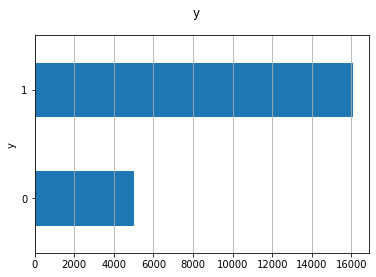

In [ ]:
fig, ax = plt.subplots()
fig.suptitle("y", fontsize=12)
dtf["y"].reset_index().groupby("y").count().sort_values(by= 
       "index").plot(kind="barh", legend=False, 
        ax=ax).grid(axis='x')
plt.show()

Imbalanced data set. Below steps will balance it. 

In [ ]:
df_grouped_by =final_df.groupby(['y'])
df_balanced = df_grouped_by.apply(lambda x: x.sample(df_grouped_by.size().min()).reset_index(drop=True))

df_balanced = df_balanced.droplevel(['y'])
df_balanced

,y,text,text_clean
0,0,"* doc-view.el (doc-view-search-backward, doc-v...",docviewel docviewsearchbackward docviewsearch ...
1,0,snappy: update 1.1.7 bottle.\n,snappy update 117 bottle
2,0,(Fdirectory_files): GCPRO encoded_directory a...,fdirectory_files gcpro encoded_directory list ...
3,0,Remove redundant whitespace.\n,remove redundant whitespace
4,0,[Security] Bump rack from 2.0.5 to 2.0.6\n\nBu...,security bump rack 205 206 bump rackhttpsgithu...
...,...,...,...
1420,1,Update git submodules\n\n* Update EditAccount ...,update git submodules update editaccount branc...
1421,1,apply security patch to address potential cros...,apply security patch address potential crosssi...
1422,1,Dom based xss vulnerability+exploit,dom based x vulnerabilityexploit
1423,1,Finished completing the Notes\n\nFinished comp...,finished completing note finished completing n...


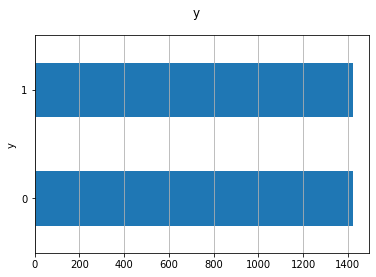

In [ ]:
fig, ax = plt.subplots()
fig.suptitle("y", fontsize=12)
df_balanced["y"].reset_index().groupby("y").count().sort_values(by= 
       "index").plot(kind="barh", legend=False, 
        ax=ax).grid(axis='x')
plt.show()

**Splitting the dataset** <br>
In order to evaluate the models performance we will split the data set into training and testing in the ratio 70:30

In [ ]:
from sklearn.model_selection import train_test_split
## split dataset
dtf_train, dtf_test = model_selection.train_test_split(df_balanced, test_size=0.3)
## get target
y_train = dtf_train["y"].values
y_test = dtf_test["y"].values

**Bag of Words:** <br>
It is a model which builds a vocabulary from a corpus and it counts the frequency of words in each document. As a result each word will become a feature and a document is represented by a vector. For example: <br>
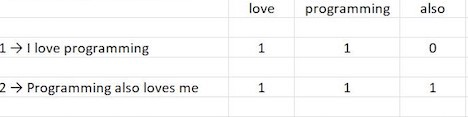 <br> Source: [NLP Tutorial for Text Classification in Python](https://medium.com/analytics-vidhya/nlp-tutorial-for-text-classification-in-python-8f19cd17b49e) <br>
Starting with **Feature Engineering**: <br> It is the process to create features from the data. Tf-idf Vectorizer has been used with a limit of 10,000 words capturing unigrams and bigrams

In [ ]:
## Count (classic BoW)
vectorizer = feature_extraction.text.CountVectorizer(max_features=10000, ngram_range=(1,2))

## Tf-Idf (advanced variant of BoW)
vectorizer = feature_extraction.text.TfidfVectorizer(max_features=10000, ngram_range=(1,2))

Create feature matrix using vectorizer

In [ ]:
corpus = dtf_train["text_clean"]
vectorizer.fit(corpus)
X_train = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_

In [ ]:
X_train.shape

(1995, 10000)

Text(0.5, 1.0, 'Sparse Matrix Sample')

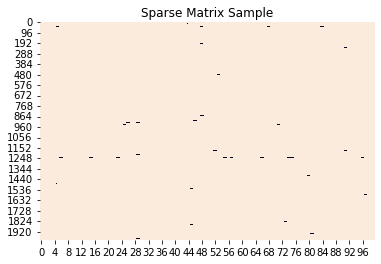

In [ ]:

sns.heatmap(X_train.todense()
[:,np.random.randint(0,X_train.shape[1],100)]==0, vmin=0, vmax=1,
 cbar=False).set_title('Sparse Matrix Sample')



The feature matrix is pretty sparse as can be seen. 

In order to look for a particular word we can look it up.If the word exists the below code will print N which means that Nth feature of the matrix is that word.  

In [ ]:
word ="malicious"
dic_vocabulary[word]

4834

**Train and Test Machine learning models**

In [ ]:
classifier = naive_bayes.MultinomialNB()

In [ ]:
## pipeline
model = pipeline.Pipeline([("vectorizer", vectorizer),  
                           ("classifier", classifier)])
## train classifier
model["classifier"].fit(X_train, y_train)
## test
X_test = dtf_test["text_clean"].values
predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)

In order to evaluate the model's performance we will use the following metrics: <br>

*   Accuracy - fraction of predictions the model got right
*   Condusion matrix - summary table which breaks down number of correct and incorrect predictions
*   ROC - a plot that illustrates true positive rate against false positives
*   Precision - fraction of relevant instances
*   Recall - Fraction of total number of relevant instances that were actually retreived. 







Accuracy: 0.88
Detail:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88       422
           1       0.88      0.88      0.88       433

    accuracy                           0.88       855
   macro avg       0.88      0.88      0.88       855
weighted avg       0.88      0.88      0.88       855



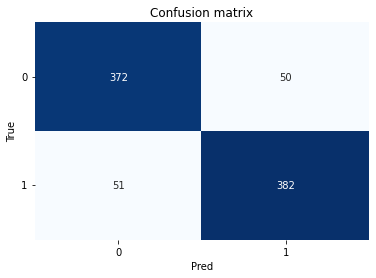

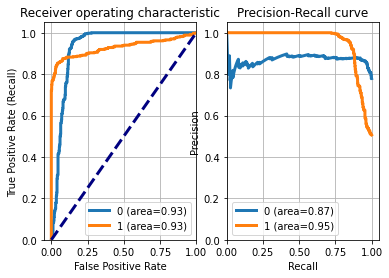

In [ ]:
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
# auc = metrics.roc_auc_score(y_test, predicted_prob, 
#                             multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
# print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

Using the lime package let's try to assess the explainability of the predictions

In [ ]:

## select observation
i = 25
txt_instance = dtf_test["text"].iloc[i]
## check true value and predicted value
print("True:", y_test[i], "--> Pred:", predicted[i], "| Prob:", round(np.max(predicted_prob[i]),2),"\n\n")
## show explanation
explainer = lime_text.LimeTextExplainer(class_names=
            np.unique(y_train))
#model.predict_on_batch(X_test)
explained = explainer.explain_instance(txt_instance, 
             model.predict_proba, num_features=3)
explained.show_in_notebook(text=txt_instance, predict_proba=False)

True: 0 --> Pred: 0 | Prob: 0.85 




**Word Embedding:**<br>
Words of same context usually appear near in the corpus so they are usually closer in the vector space as well. Word2Vec produces a vector space typically of several hundred dimensions with each unique word in the corpus. We can use 2 approaches skip-gram or Continuous bag of words<br>
Instead of using pretrained models we will be training our own Word2vec model. <br>
When fitting word2vec we need to specify target size, I have used 300. Window for which I have used mean lenght of text from corpus, skip-grams 

In [ ]:
corpus = dtf_train["text_clean"]

## create list of lists of unigrams
lst_corpus = []
for string in corpus:
   lst_words = string.split()
   lst_grams = [" ".join(lst_words[i:i+1]) 
               for i in range(0, len(lst_words), 1)]
   lst_corpus.append(lst_grams)

## detect bigrams and trigrams
bigrams_detector = gensim.models.phrases.Phrases(lst_corpus, 
                 delimiter=" ".encode(), min_count=5, threshold=10)
bigrams_detector = gensim.models.phrases.Phraser(bigrams_detector)
trigrams_detector = gensim.models.phrases.Phrases(bigrams_detector[lst_corpus], 
            delimiter=" ".encode(), min_count=5, threshold=10)
trigrams_detector = gensim.models.phrases.Phraser(trigrams_detector)

In [ ]:
## fit w2v
nlp = gensim.models.word2vec.Word2Vec(lst_corpus, size=300,   
            window=8, min_count=1, sg=1, iter=30)

In [ ]:
word = "malicious"
nlp[word].shape

(300,)

Use the word vectors in neural networks as weights. For this purpose the corpus will be transformed into padded sequences of words. After this an embedding matrix is created so that vector of word with id N is located in Nth row. Finally a neural network is built with an embedding layer that weighs every word in the sequence. 

In [ ]:
## tokenize text
tokenizer = kprocessing.text.Tokenizer(lower=True, split=' ', 
                     oov_token="NaN", 
                     filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(lst_corpus)
dic_vocabulary = tokenizer.word_index
## create sequence
lst_text2seq= tokenizer.texts_to_sequences(lst_corpus)
## padding sequence
X_train = kprocessing.sequence.pad_sequences(lst_text2seq, 
                    maxlen=15, padding="post", truncating="post")

For every text message we have in the corpus now an id sequence of length 15 

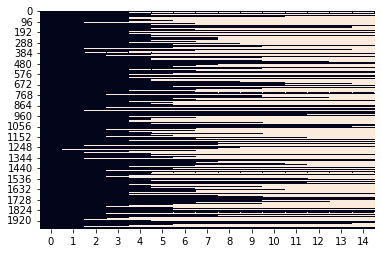

In [ ]:
sns.heatmap(X_train==0, vmin=0, vmax=1, cbar=False)
plt.show()

Below code will help us visualize how the train set has been transformed into a sequence with padding and vocab

In [ ]:
i = 0

## list of text: ["fix the xss vulnerability", ...]
len_txt = len(dtf_train["text_clean"].iloc[i].split())
print("from: ", dtf_train["text_clean"].iloc[i], "| len:", len_txt)

## sequence of token ids: [[1, 2, 3], ...]
len_tokens = len(X_train[i])
print("to: ", X_train[i], "| len:", len(X_train[i]))

## vocabulary: {"fix":1, "vulnerability":2, "crosssite":3, ...}
print("check: ", dtf_train["text_clean"].iloc[i].split()[0], 
      " -- idx in vocabulary -->", 
      dic_vocabulary[dtf_train["text_clean"].iloc[i].split()[0]])

print("vocabulary: ", dict(list(dic_vocabulary.items())[0:5]), "... (padding element, 0)")

from:  set proper directory permission data dir linux directory permission 777 extremely insecure never necessary | len: 14
to:  [ 146 1956  160   45  111 3269  824  160   45  979 5257   36 1539 1432
    0] | len: 15
check:  set  -- idx in vocabulary --> 146
vocabulary:  {'NaN': 1, '0': 2, 'fix': 3, '1': 4, 'add': 5} ... (padding element, 0)


Same feature engineering needs to be done on test set. 

In [ ]:
corpus = dtf_test["text_clean"]

## create list of n-grams
lst_corpus = []
for string in corpus:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i+1]) for i in range(0, 
                 len(lst_words), 1)]
    lst_corpus.append(lst_grams)
    
## detect common bigrams and trigrams using the fitted detectors
lst_corpus = list(bigrams_detector[lst_corpus])
lst_corpus = list(trigrams_detector[lst_corpus])
## text to sequence with the fitted tokenizer
lst_text2seq = tokenizer.texts_to_sequences(lst_corpus)

## padding sequence
X_test = kprocessing.sequence.pad_sequences(lst_text2seq, maxlen=15,
             padding="post", truncating="post")


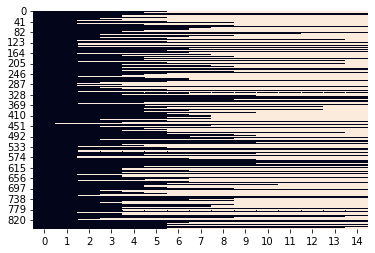

In [ ]:
sns.heatmap(X_test==0, vmin=0, vmax=1, cbar=False)
plt.show()

Now that we have Test and Train data sets we will create matrix embedding which will act as weight matrix in our neural network classifier. 

In [ ]:
## start the matrix (length of vocabulary x vector size) with all 0s
embeddings = np.zeros((len(dic_vocabulary)+1, 300))
for word,idx in dic_vocabulary.items():
    ## update the row with vector
    try:
        embeddings[idx] =  nlp[word]
    ## if word not in model then skip and the row stays all 0s
    except:
        pass

In [ ]:
word = "malicious"
print("dic[",word,"]:", dic_vocabulary[word], "|idx")
print("embeddings[idx]:", embeddings[dic_vocabulary[word]].shape, 
      "|vector")

dic[ malicious ]: 31 |idx
embeddings[idx]: (300,) |vector


Now we can build the deep learning model. The embedding matrix created in above step will be used as first embedding layer which will help in classifying the commit message as per their type.<br> 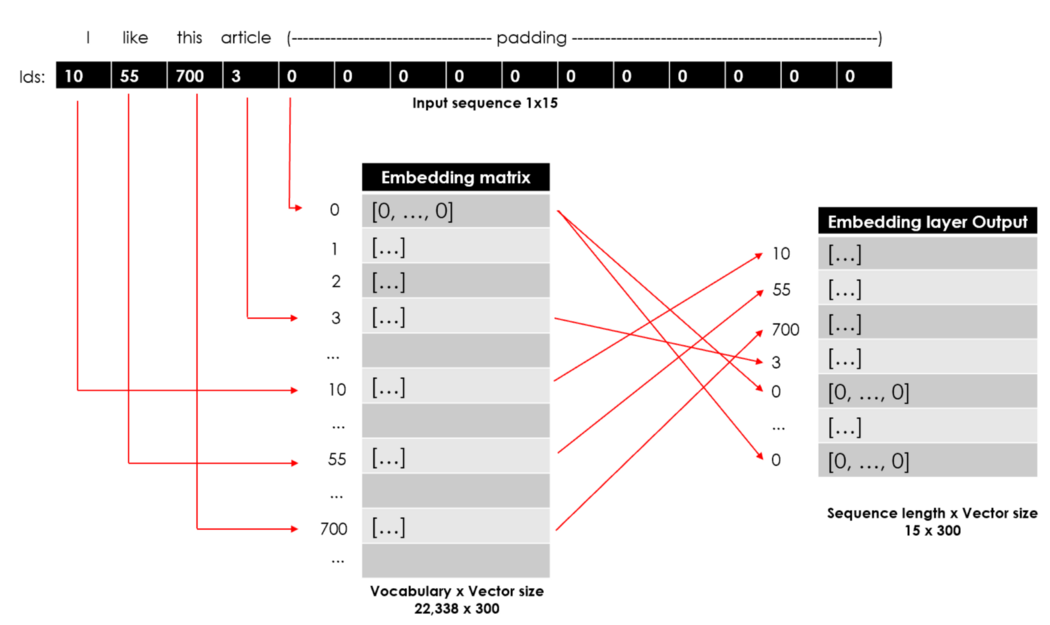 <br> Source: [NLP Tf-Idf vs Word2Vec vs BERT](https://towardsdatascience.com/text-classification-with-nlp-tf-idf-vs-word2vec-vs-bert-41ff868d1794)

In [ ]:
## code attention layer
def attention_layer(inputs, neurons):
    x = layers.Permute((2,1))(inputs)
    x = layers.Dense(neurons, activation="softmax")(x)
    x = layers.Permute((2,1), name="attention")(x)
    x = layers.multiply([inputs, x])
    return x

## input
x_in = layers.Input(shape=(15,))
## embedding
x = layers.Embedding(input_dim=embeddings.shape[0],  
                     output_dim=embeddings.shape[1], 
                     weights=[embeddings],
                     input_length=15, trainable=False)(x_in)
## apply attention
x = attention_layer(x, neurons=15)
## 2 layers of bidirectional lstm
x = layers.Bidirectional(layers.LSTM(units=15, dropout=0.2, 
                         return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(units=15, dropout=0.2))(x)
## final dense layers
x = layers.Dense(64, activation='relu')(x)
y_out = layers.Dense(3, activation='softmax')(x)
## compile
model = models.Model(x_in, y_out)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 15)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 15, 300)      4889700     ['input_1[0][0]']                
                                                                                                  
 permute (Permute)              (None, 300, 15)      0           ['embedding[0][0]']              
                                                                                                  
 dense (Dense)                  (None, 300, 15)      240         ['permute[0][0]']                
                                                                                              

Now we can train the model and check its performance

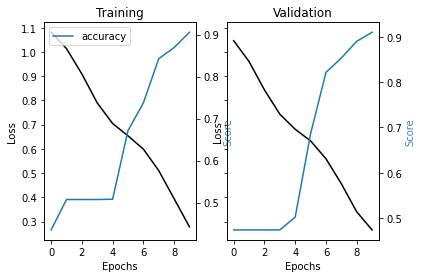

In [ ]:
## encode y
dic_y_mapping = {n:label for n,label in 
                 enumerate(np.unique(y_train))}
inverse_dic = {v:k for k,v in dic_y_mapping.items()}
y_train = np.array([inverse_dic[y] for y in y_train])
## train
training = model.fit(x=X_train, y=y_train, batch_size=256, 
                     epochs=10, shuffle=True, verbose=0, 
                     validation_split=0.3)
## plot loss and accuracy
metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True)
ax[0].set(title="Training")
ax11 = ax[0].twinx()
ax[0].plot(training.history['loss'], color='black')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss', color='black')
for metric in metrics:
    ax11.plot(training.history[metric], label=metric)
ax11.set_ylabel("Score", color='steelblue')
ax11.legend()
ax[1].set(title="Validation")
ax22 = ax[1].twinx()
ax[1].plot(training.history['val_loss'], color='black')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss', color='black')
for metric in metrics:
     ax22.plot(training.history['val_'+metric], label=metric)
ax22.set_ylabel("Score", color="steelblue")
plt.show()

In some epochs the accuracy reached 0.9 which is nice. 

In [ ]:
## test
predicted_prob = model.predict(X_test)
predicted_y = [dic_y_mapping[np.argmax(pred)] for pred in 
             predicted_prob]

Accuracy: 0.88
Detail:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88       422
           1       0.88      0.88      0.88       433

    accuracy                           0.88       855
   macro avg       0.88      0.88      0.88       855
weighted avg       0.88      0.88      0.88       855



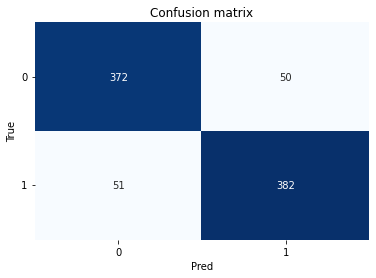

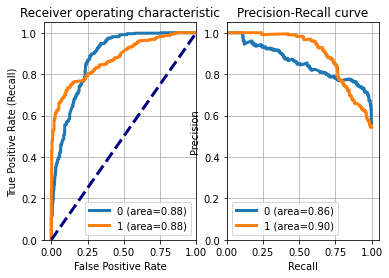

In [ ]:
import sklearn.metrics as metrics
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
# auc = metrics.roc_auc_score(y_test, predicted_prob, 
#                             multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
# print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

**References**:
1. https://towardsdatascience.com/introduction-to-git-data-extraction-and-analysis-in-python-e7e2bf9b4606
2. https://towardsdatascience.com/text-pre-processing-stop-words-removal-using-different-libraries-f20bac19929a
3. https://towardsdatascience.com/nlp-preprocessing-with-nltk-3c04ee00edc0
4. https://medium.com/swlh/how-to-train-word2vec-model-using-gensim-library-115b35440c90
5. Keywords related to vulnerabilities: [Identifying the characteristics of vulnerable code changes: an empirical study](https://www.researchgate.net/figure/Keywords-Associated-with-Vulnerabilities_tbl1_286077750)
6. [All the Things You Can Do With GitHub API and Python](https://towardsdatascience.com/all-the-things-you-can-do-with-github-api-and-python-f01790fca131)

7. https://towardsdatascience.com/using-word2vec-to-analyze-news-headlines-and-predict-article-success-cdeda5f14751
8. https://coderzcolumn.com/tutorials/machine-learning/how-to-use-lime-to-understand-sklearn-models-predictions